# Build a Stocks Price Prediction App powered by  Snowflake, AWS, Python and Streamlit - Part 1 of 3

A comprehensive guide to develop machine learning applications from start to finish.

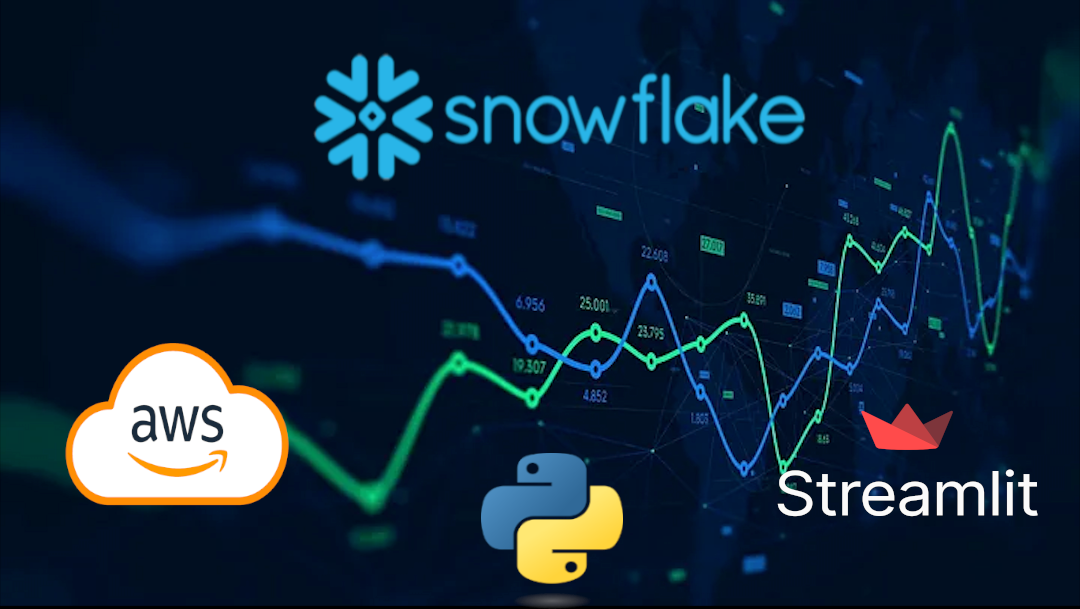


## Introduction

In my previous articles, I demonstrated how to collect financial data in an automated manner and store it in AWS S3 buckets. Additionally, we performed exploratory data analysis (EDA). Now, let's proceed with our journey to develop a stock predictions app.

In this Three series articles, we'll develop a complete machine learning project using a variety of techniques and tools including AWS, Snowflake, Python, Snowpark, and Streamlit. The final outcome will be a web application that enables us to forecast future stock prices for Google

## Project Layout

Here are the high-level steps for this project. In this article we will cover first two sections i.e. **Data collection** & **Data storage**

1. **<u>Data collection</u>**: Automatically download the stock historical prices data in csv format and save it AWS S3 bucket.


2. **<u>Data storage</u>**: Store the data in a Snowflake data warehouse by creating data pipe between AWS and Snowflake.


3. **Data Extraction, Preprocessing & EDA**: Extract & Pre-process the data using Python and perform basic Exploratory Data Analysis.


4. **Machine Learning Model development**: Develop a machine learning model, Train the model on historical data, Evaluate the model and perform hyper parameter tunning 


5. **Machine Learning Model deployment**: Deploy the final model on Snowflake.


6. **Web App development**: Build a web app using Streamlit and Python to interact with the deployed model and display the predictions. And Deploy the final app on Streamlit Cloud.

## 1. Data Collection

In this step we will create an AWS Lambda function that will run the Python code to retrieve the stock prices of Google and save it as a CSV file in an AWS S3 bucket.

As I have already covered this topic in depth previously, I will not spend much time on this step. Please refer to the following article to set up an AWS S3 bucket, Lambda function, and daily automation

https://medium.com/jovianml/automate-web-scraping-using-python-aws-lambda-amazon-s3-amazon-eventbridge-cloudwatch-c4c982c35fa7

Please use following Naming, Configurations & Supplementary files for this project  

* Set AWS S3 bucket name as **`stocksprice-prediction`**
* Use this zip file for Layer creation : https://github.com/vinodvidhole/stockprice-predictions/blob/main/AWS/AWSLambdaLayer/YF_39.zip
* Set Runtime for Layer as **`Python 3.9`** 
* Set Runtime for Lambda Function as **`Python 3.9`**
* Use this lambda_function.py : https://github.com/vinodvidhole/stockprice-predictions/blob/main/AWS/lambda_function.py
* Set the run schedule for Lambda function as **`24 Hours`** (once a day) 


After successful completion of this set up, you will see a daily GOOG_YYYY-MM-DD_HHMM.csv file which contains Stock prices of Google.

## 2. Data storage

In this phase, we are are going to learn about one of the leading data platform Snowflake and save the csv format pricing data into relational database. We will also create a seamless integration between AWS & Snowflake and automatically pump the data using Snowpipe as soon as file generated in AWS. 

We will cover following topics 
* Quick Introduction of Snowflake
* Configure Access Permissions on AWS 
* Create a Cloud Storage Integration in Snowflake
* Update Trust relationships of AWS IAM Role
* Access S3 bucket from Snowflake & Load the data
* Automate Data pipeline using Snowpipe
* Text & Monitor the Data Pipe Automation

### What is Snowflake
Snowflake is a cloud-based data warehousing platform that provides an easy, scalable, and secure solution for storing, processing, and analyzing large amounts of data. It separates compute and storage, enabling users to scale their resources independently and pay only for what they use. Snowflake is also designed to handle a wide range of data types and workloads, from structured to semi-structured and unstructured data. Its unique architecture allows for seamless sharing of data across organizations and users, making it an ideal choice for data-driven enterprises.

#### Quick Start Guide on Snowflake

Please create Snowflake 30 days Trial account using [this](https://signup.snowflake.com/) link. 

You can login to snowflake web console using https://app.snowflake.com/. On the Left Side there is navigation panel. 

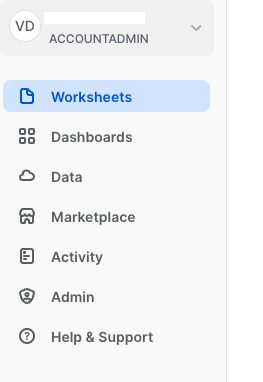


#### Worksheets 
Worksheets provide a simple way for you to write SQL queries (DML and DDL), see the results, and interact with them. 

Click the `Worksheets` on left panel and the click **`+ Worksheet`** button on top right. 
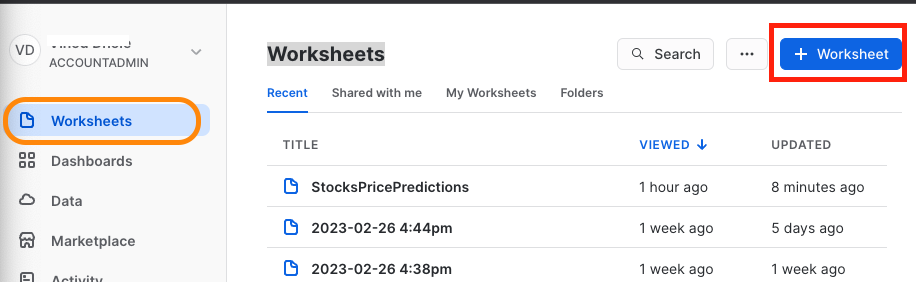

You can rename the worksheet as shown below 
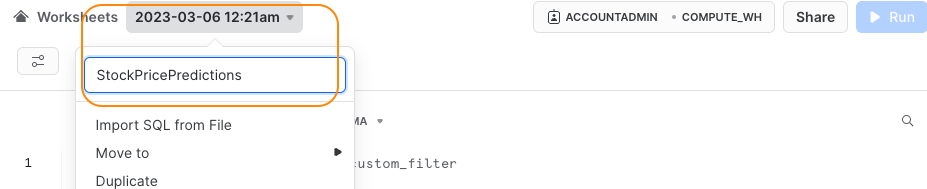

Following screen-shot indicates which User Roles & Warehouse the active for the current worksheet 
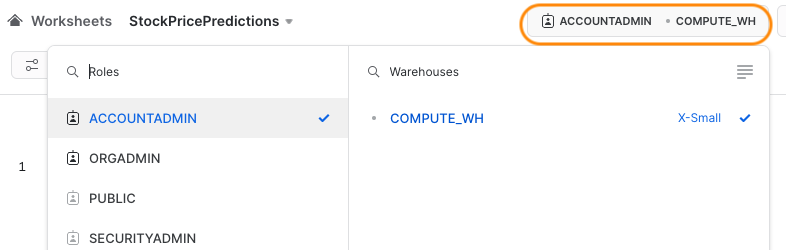

This will Indicate the selected Database and schema.
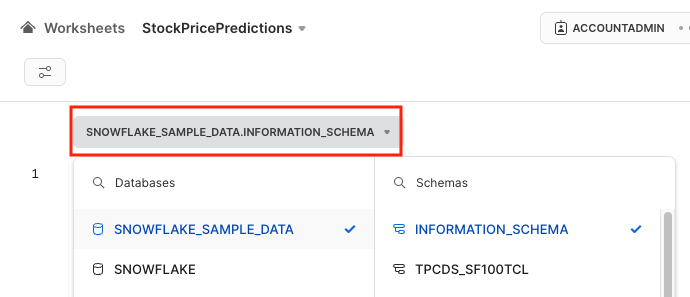

Lets get the action started... (All the code written on the Worksheet is available [here](https://github.com/vinodvidhole/stockprice-predictions/blob/main/StockPricePredictions_WorkSheets.txt).)

Type following sql to create the WareHouse **PRICE_PRED**

`CREATE OR REPLACE WAREHOUSE PRICE_PRED WITH WAREHOUSE_SIZE='X-SMALL';`

You can select the entire statement or just move the cursor on the sql statement and the click **Run** button located on top right to execute the sql. 

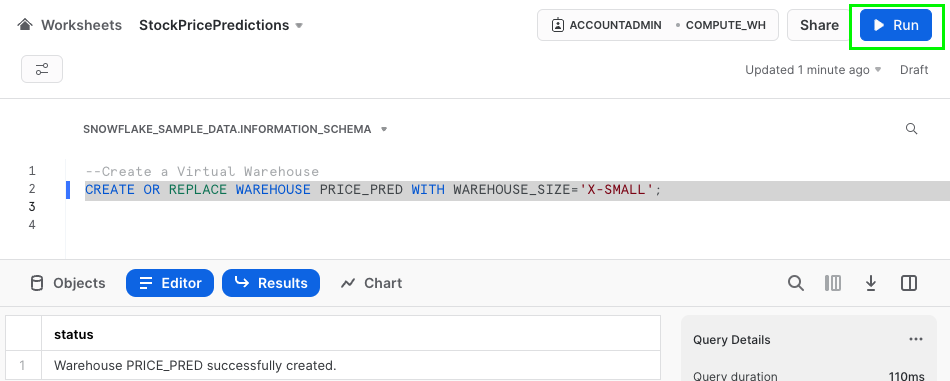

You can navigate to **Admin -> Warehouse** on left panel to checkout newly created warehouse 

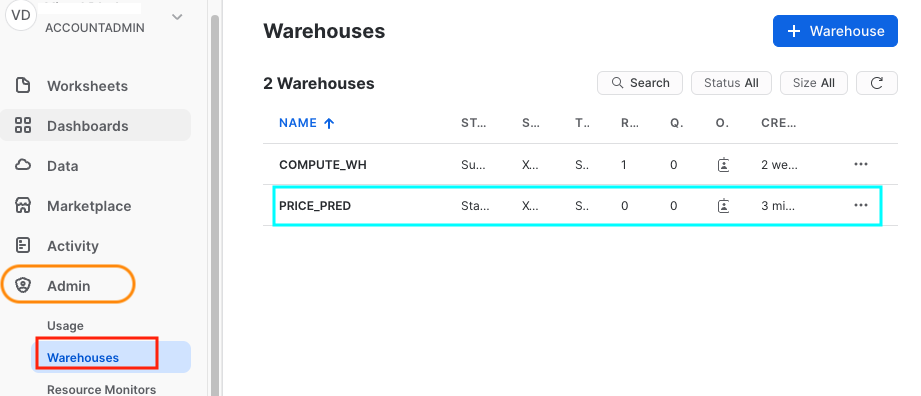

Now go back to StockPricePredictions and select the PRICE_PRED warehouse.

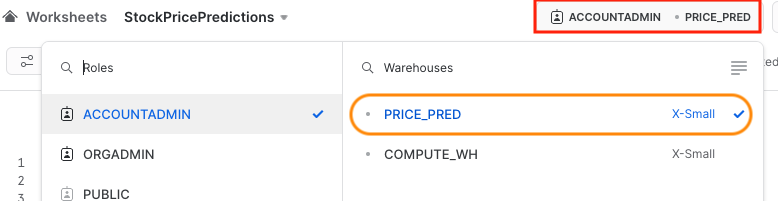

After that run following statements to create a new database **PRICE_PRED_DB** & **PRICE_PRED_SCHEMA**


`CREATE OR REPLACE DATABASE PRICE_PRED_DB;`

`CREATE OR REPLACE SCHEMA PRICE_PRED_SCHEMA;`

You can navigate to **Data -> Database** on left panel to checkout newly created Database & Schema 

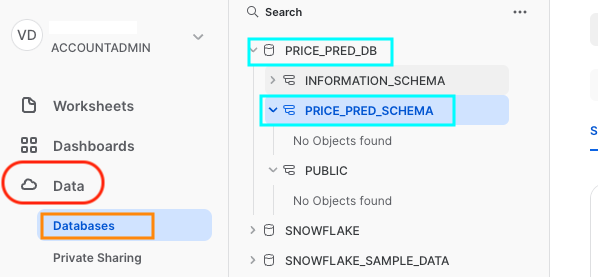

Lets Create a Table to the store the prices, execute following DDL on the WorkSheet<br> 

`create or replace table historical_prices`<br> 
`(`<br>
`    High float,`<br>
`    Low float,`<br>
`    Open float,`<br>
`    Close float,`<br>
`    Volume integer,`<br>
`    AdjClose float,`<br>
`    Date Date,`<br>
`    Ticker varchar`<br>
`);`<br>


You can run select query on the **historical_prices** table, but table would be empty.<br> 

`select * from historical_prices;`<br>

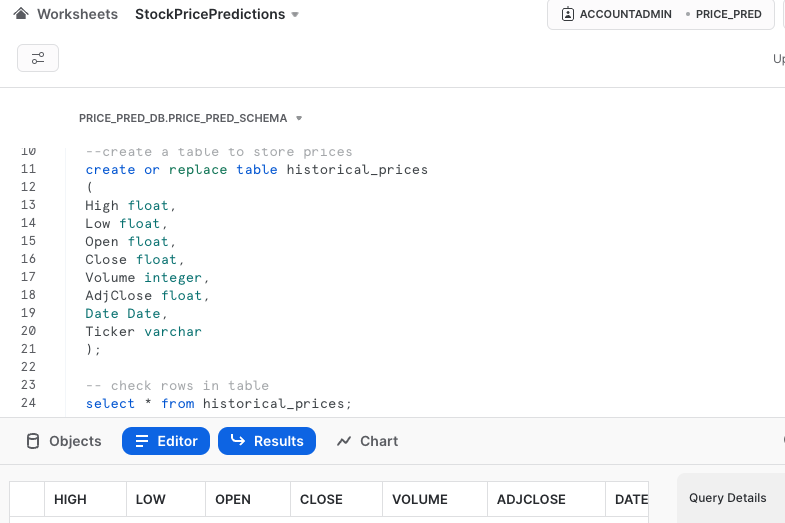<br>

Table **historical_prices** should be present at **Data -> Database -> PRICE_PRED_DB -> PRICE_PRED_SCHEMA -> Tables**

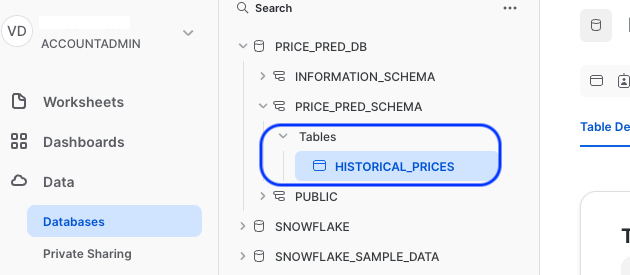

Now are we halfway done, Table is ready.Next step is Set-up integration between AWS S3 bucket (where the data file is located) & Snowflake tables 

### Configure Access Permissions on AWS 

Here we will create required IAM Policy & Roles on AWS side 


#### 1. Creating an IAM Policy

Sign in to your AWS Account, go-to Console Home. On top of the page, there should be a search bar. Type “IAM” in the search bar. From the populated results, click the first service “IAM”.

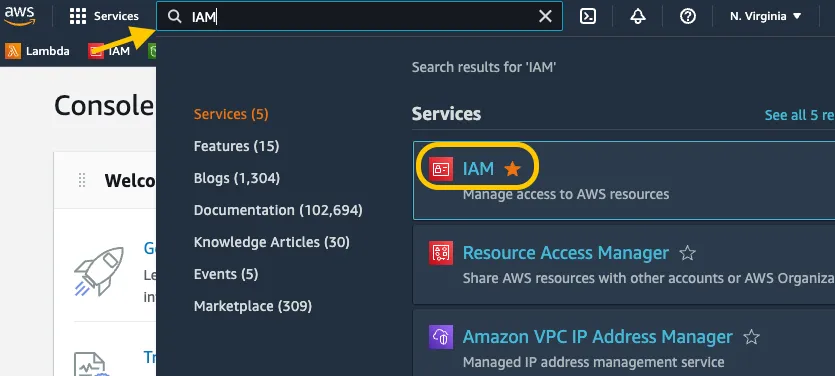

* On the left panel, select “Policies” and then button “Create Policies” located at top right.

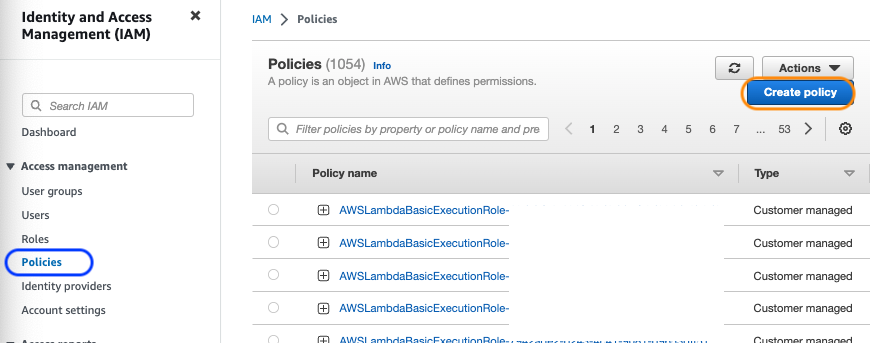

* On the next Page, Select the **JSON** tab and paste following text. Same text is available [here](https://github.com/vinodvidhole/stockprice-predictions/blob/main/AWS/PricePredPolicy.json).<br>

`{`<br>
`      "Version": "2012-10-17",`<br>
`      "Statement": [`<br>
`          {`<br>
`              "Effect": "Allow",`<br>
`              "Action": [`<br>
`			  "s3:PutObject",`<br>
`			  "s3:GetObject",`<br>
`			  "s3:GetObjectVersion",`<br>
`			  "s3:DeleteObject",`<br>
`			  "s3:DeleteObjectVersion"`<br>
`			  ],`<br>
`              "Resource": "arn:aws:s3:::stocksprice-prediction/*"`<br>
`          },`<br>
`          {`<br>
`              "Effect": "Allow",`<br>
`              "Action": [`<br>
`			  		"s3:ListBucket",`<br>
`			  	  	"s3:GetBucketLocation"`<br>			  
`			  ],`<br>
`              "Resource": "arn:aws:s3:::stocksprice-prediction",`<br>
`			  "Condition":{`<br>
`			  		"StringLike" :{`<br>
`						"s3:prefix":[`<br>
`							"*"`<br>
`					]`<br>
`					}`<br>
`			  }`<br>
`          }`<br>
`      ]`<br>
`  }`<br>

  
  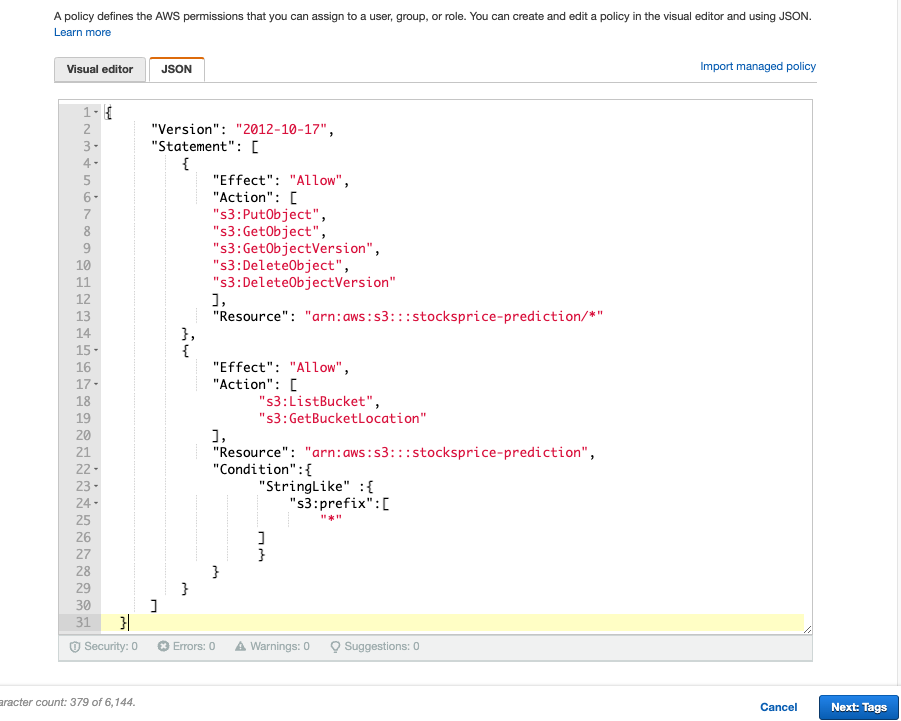<br>

* Click **Next** button 2 times
* On the Review policy page provide policy name as **PricePredPolicy** & appropriate Description.
* Then Click on **Create Policy**, PricePredPolicy should be available on the list. 

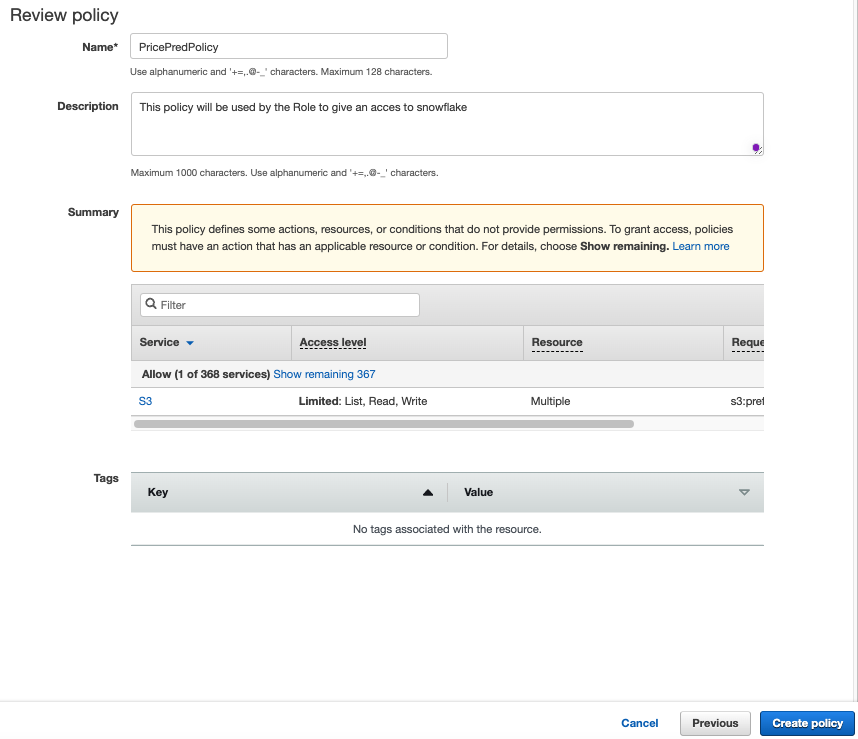

#### 2. Create the IAM Role in AWS

Sign in to your AWS Account, go-to Console Home. On top of the page, there should be a search bar. Type “IAM” in the search bar. From the populated results, click on the first service, i.e. “IAM”

* On the left panel, Click on “Roles” which will open a page listing all available roles. Click the “Create role” button.

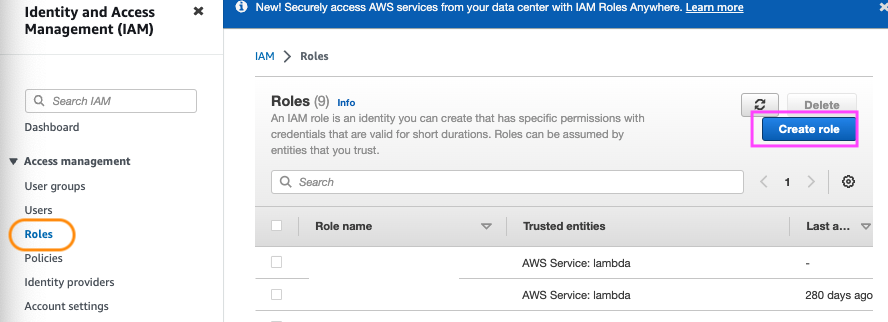

* Select Trusted entity type as **AWS account**
* select **This account (AWS Acct number)** in An AWS account section
* In Option select fist check box (Require external ID (Best practice when a third party will assume this role)
* This will enable External ID text box, For now type **123**, later on we will replace this text.
* Click on **Next** 

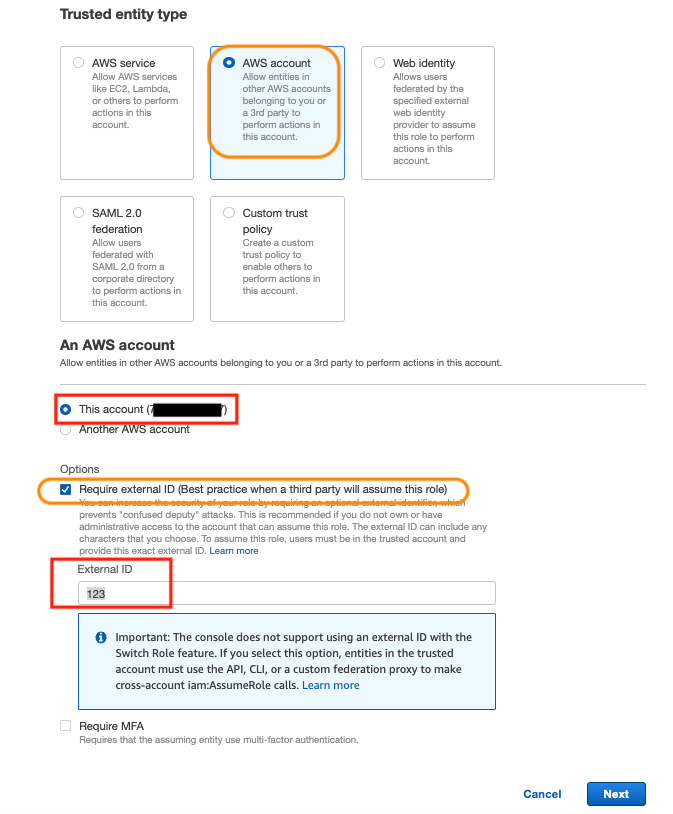

* In Add Permissions page , select earlier creates **PricePredPolicy** and click Next 

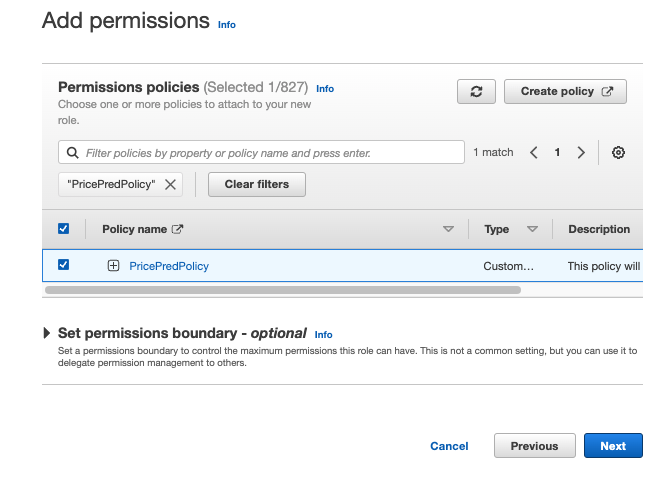

* On the Role details page provide Role name as **PricePredRole** & appropriate Description.
* Then Click on Create Role, PricePredRole should be available on the list.
* Select the **PricePredRole**, This should open Summary page. Copy the ARN by clicking Copy icon. 
* Save this ARN role on the notepad for future use.

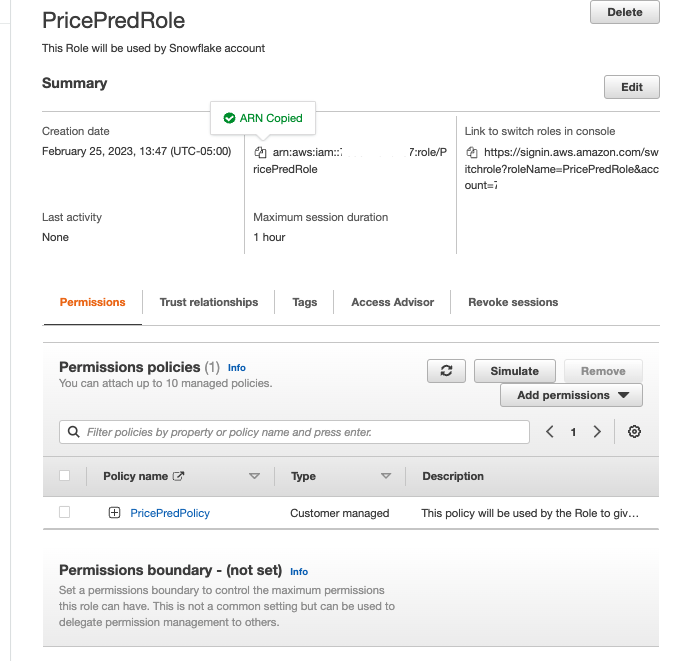


#### 3. Upload the initial pricing file

* Download [this](https://github.com/vinodvidhole/stockprice-predictions/blob/main/AWS/GOOG.csv) file to local computer.
* Go to S3 Bucket and select **stocksprice-prediction**
* Click on Upload button, Then Add files. Select the GOOG.csv downloaded earlier. 
* Click Upload button, GOOG.csv should be available in the S3 bucket.

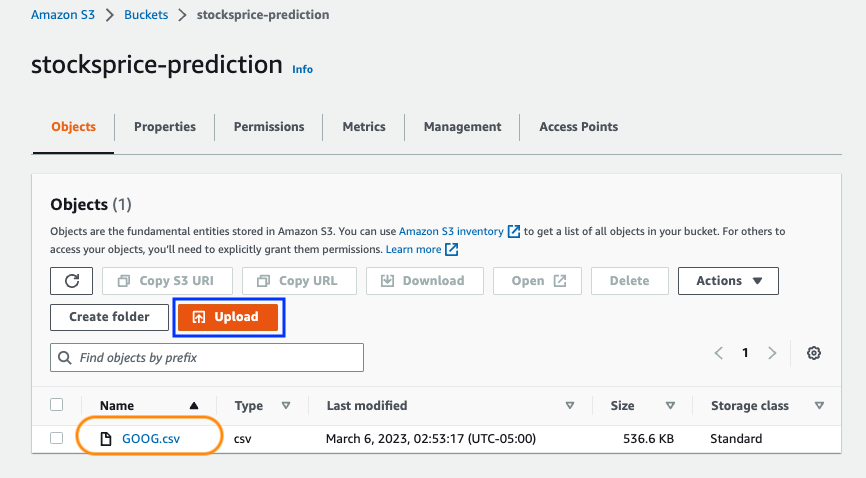

### Create a Cloud Storage Integration in Snowflake

Lets go back to Snowflake side, login to snowflake web console using https://app.snowflake.com/ and open **StockPricePredictions** Worksheet.


Create storage integration object by running following statement on worksheet. make sure to set **storage_aws_role_arn** as ARN Role text copied in the notepad from earlier step<br> 

`CREATE OR REPLACE STORAGE INTEGRATION aws_s3_integration`<br>
`type = external_stage`<br>
`storage_provider='S3'`<br>
`enabled=true`<br>
`storage_aws_role_arn='arn:aws:iam::XXXXXXXXXX:role/PricePredRole'`<br>
`storage_allowed_locations=('s3://stocksprice-prediction/');`<br>


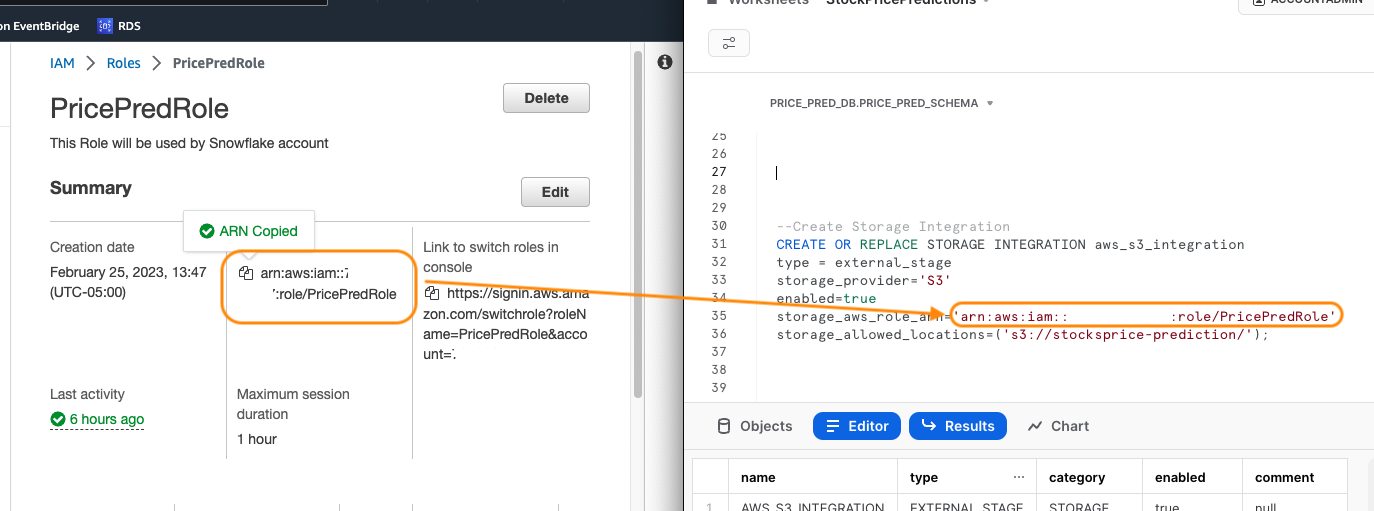<br>

Run following command to get description of the storage integration<br> 

`DESC INTEGRATION AWS_S3_INTEGRATION;`<br>

For the result table, copy the **property_value** of **STORAGE_AWS_IAM_USER_ARN** and **STORAGE_AWS_EXTERNAL_ID** and save it in notepad for future use <br>

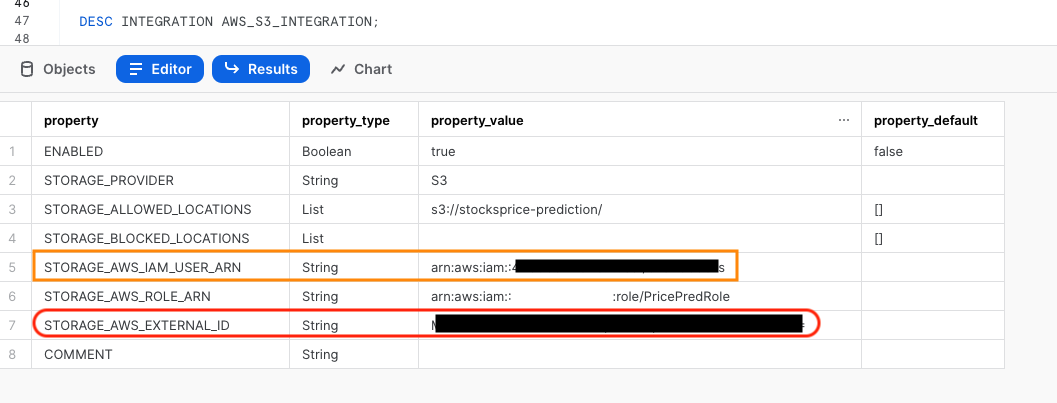<br>

### Update Trust relationships of AWS IAM Role

This is the last piece of puzzle to complete the handshake between S3 bucket & Snowflake.

* Login to AWS console , navigate to IAM -> Roles , open PricePredRole.
* go to Trust relationships tab and then click **Edit trust policy** button
* on the Trusted entities tab you need to replace 2 values as mentioned  below  
* Set **STORAGE_AWS_IAM_USER_ARN** value (saved earlier) to **"AWS":** 
* Set **STORAGE_AWS_EXTERNAL_ID** value (saved earlier) to **"sts:ExternalId":** 
* Click **Update Policies** button to save the changes.

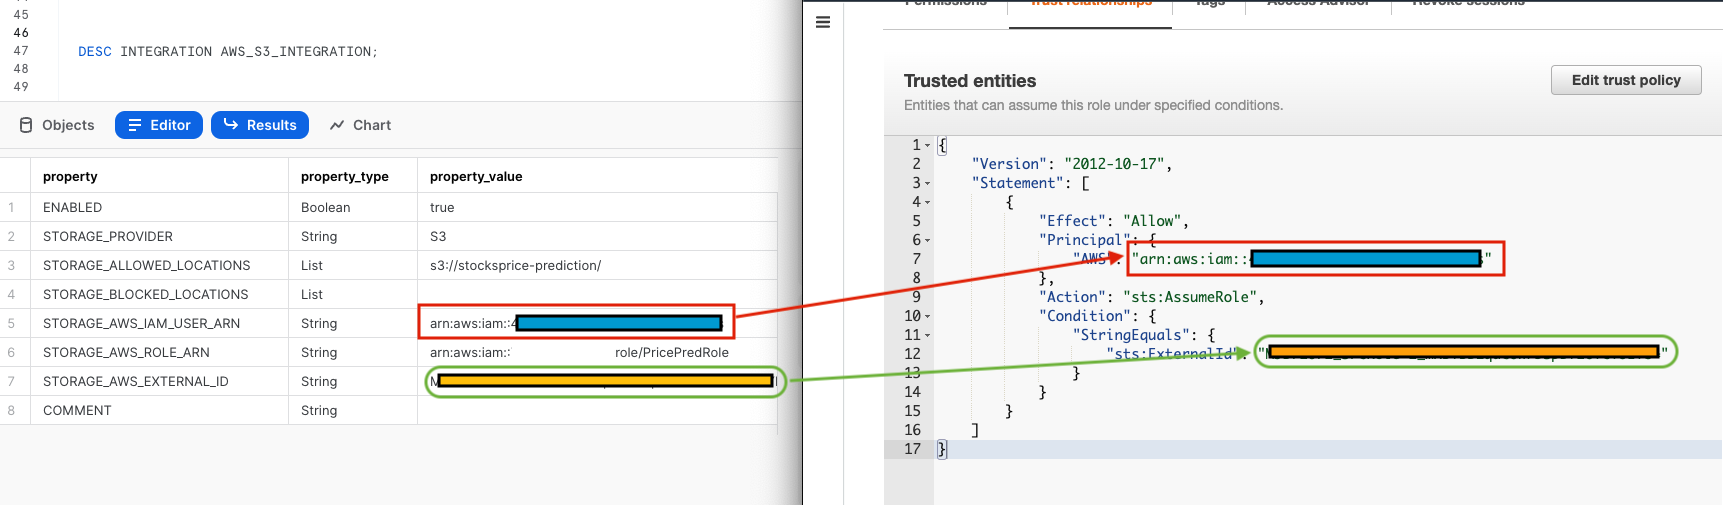




### Access S3 bucket from Snowflake & Load the data

We have set up all the required permissions & configurations on both ends, now lets see some magic. we will access the data files and pump the data into the table, and also we can files available in S3 from snowflake.

login to Snowflake and open StockPricePredictions worksheet

#### Creating Permissions  & File Formats 

Execute following commands in StockPricePredictions worksheet

* Providing permissions to **ACCOUNTADMIN** role to use integration<br> 

`GRANT USAGE ON INTEGRATION AWS_S3_INTEGRATION TO ROLE ACCOUNTADMIN;`<br>

* Creating file format on Snowflake, to support the .csv files of S3 bucket<br>


`CREATE OR REPLACE FILE FORMAT csv`<br> 
`type='csv'`<br>
`field_delimiter = ',' `<br>
`record_delimiter = '\n'`<br>
`skip_header = 1;`<br>


#### Creating Stage 

This is one of the important step, we will need to Create stage in order to talk with external integration in this case AWS S3.<br>

Execute following command in StockPricePredictions worksheet<br>

`CREATE OR REPLACE STAGE price_pred_aws_stage`<br>
`storage_integration = aws_s3_integration`<br>
`file_format = csv`<br>
`url = 's3://stocksprice-prediction/';`<br>


#### Checking available files on S3
following query will display all available files linked with the stage (i.e. available ib S3 bucket)<br> 

`list @price_pred_aws_stage;`<br>


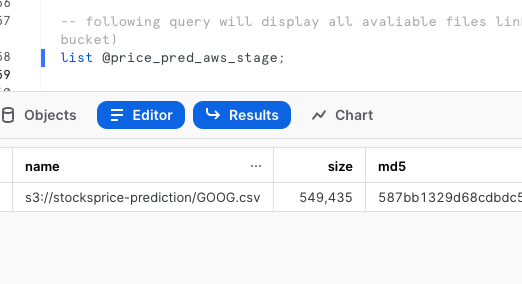<br>

#### Load data files from AWS S3 to Snowflake tables

Lets take look at how to load the data and different variants.

* Fist We are check the Total rows in the table **historical_prices**<br>

`select count(*) from historical_prices;`<br>

This will show us 0 count,as its a newly create table<br> 

* Run following command to copy data into **historical_prices** from **GOOG.csv** locate at S3<br>

`COPY INTO historical_prices FROM @price_pred_aws_stage/GOOG.csv
file_format=CSV;`<br>

* Lets check the table and see of any rows are loaded<br>

`select * from historical_prices;`<br>

you should see total 4667 rows in the table.<br>

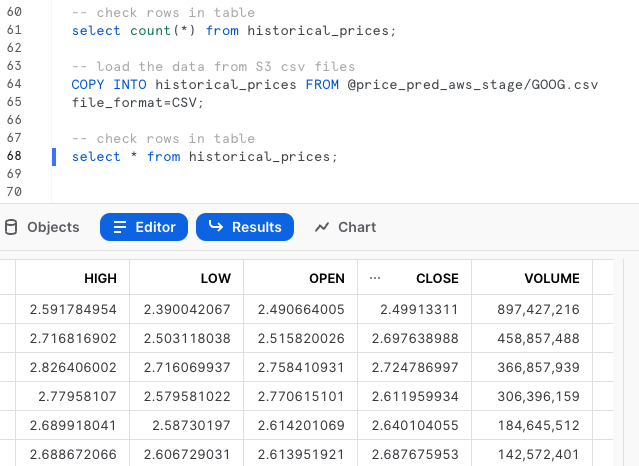<br>

* If you try to run the same COPY INTO statement again , Snowflake will not load the data as it was already loaded.<br>

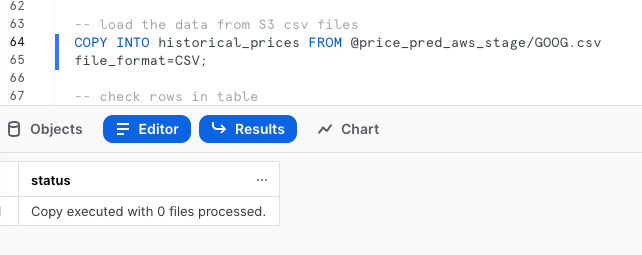<br>

* There are some parameters like **PATTERN, ON_ERROR, FORCE, PURGE** etc, you can refer [this](https://docs.snowflake.com/en/sql-reference/sql/copy-into-table) Snowflake documentation to explore this options. I will also provide the link to file which will contain all additional statements.


* We will use the following statement to perform the data copy, this will perform bulk load of all available non processed csv files from S3, and if there is any bad data it will skip that row and continue the bulk load  

`copy into historical_prices from @price_pred_aws_stage `<br>
`    file_format=csv `<br>
`    pattern = '.*csv.*'`<br>
`    on_error = 'Continue'`<br>

* Now lets check if we can control S3 bucket from Snowflake,  I am trying to remove the file from the bucket, execute following statements.<br> 

`remove @price_pred_aws_stage/GOOG.csv;`<br>

`list @price_pred_aws_stage;`<br>

You can see list @stage statement will not show any data as we have successfully delete the S3 data from from Snowflake.<br>
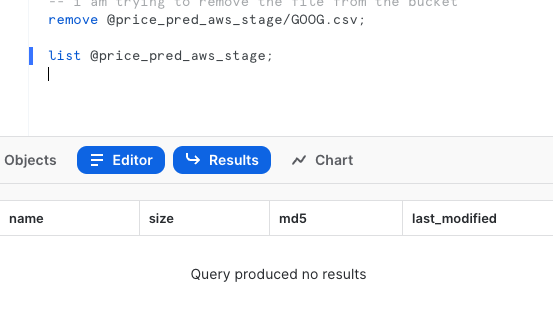<br>

You can go back to AWS console to verify, the S3 bucket should be empty.<br>
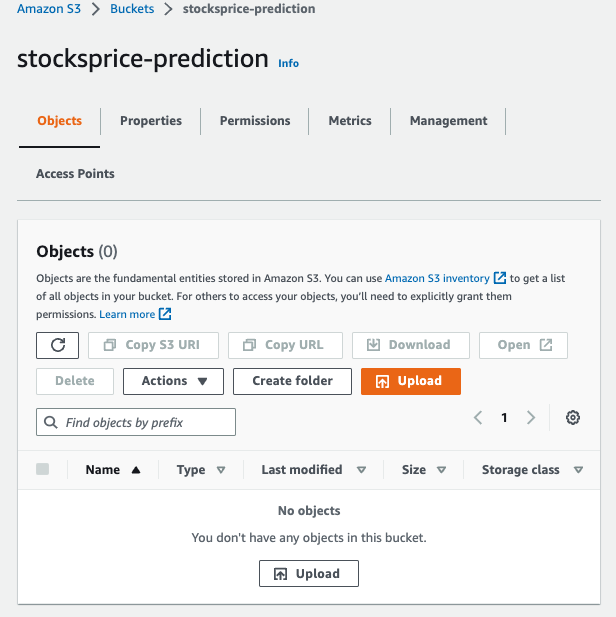<br>


### Automate Data pipeline using Snowpipe

We were able to establish the integration between Snowflake & S3 bucket, we also load the data by running COPY INTO statements on Snowflake side. Now its time to Automate this process.


#### Create a Pipe with Auto-Ingest Enabled

The following statement creates a pipe named **get_stocks_data_pipe** in the schema. The pipe loads the data from stage into the historical_prices table, run this on SnowFlake.<br>

`create or replace pipe get_stocks_data_pipe`<br>
`  auto_ingest=true`<br>
`  as`<br>
`    copy into historical_prices from @price_pred_aws_stage `<br>
`    file_format=csv `<br>
`    pattern = '.*csv.*'`<br>
`    on_error = 'Continue'; `<br>


Please run following statement to display snow pipe definition.<br>

`SHOW PIPES;`<br>

Copy the value present in the **notification_channel** column from  result and save it in notepad for future use.<br>

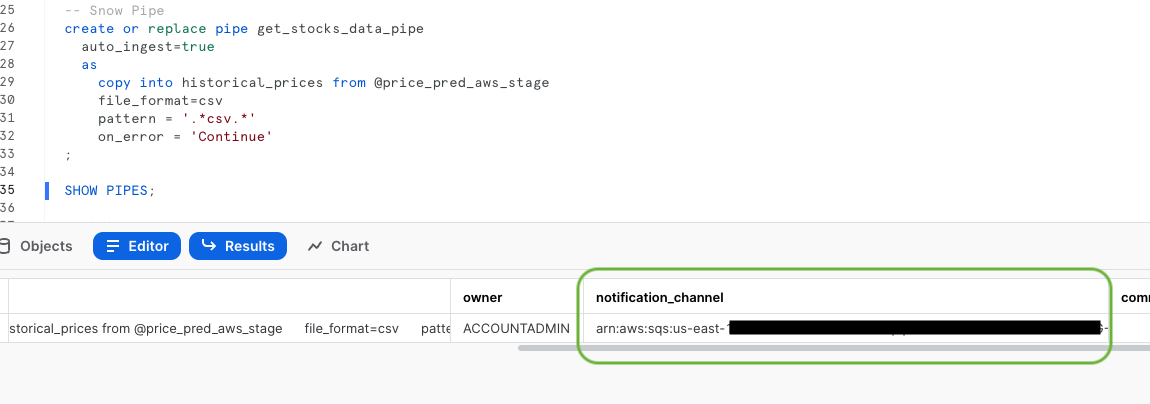<br>


#### Configure Event Notifications in AWS S3 Bucket

This the final step for the Automation.

* Now switch back to AWS Console, and open S3 bucket **stocksprice-prediction**  
* Click on Properties Tab

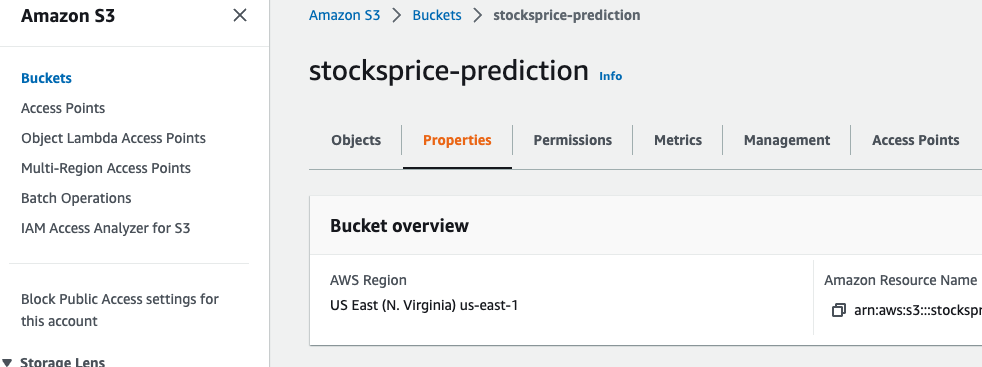

* Scroll down and click **Create event notification** button.

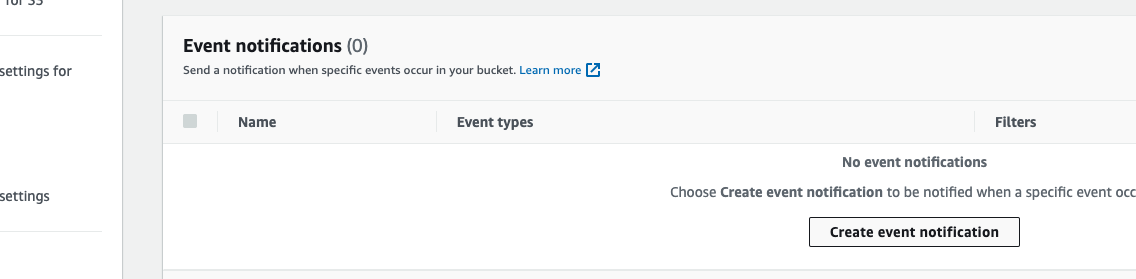

* Provide proper Evant name like snowpipe-event, Then in the **Event types** section select **All object create events**

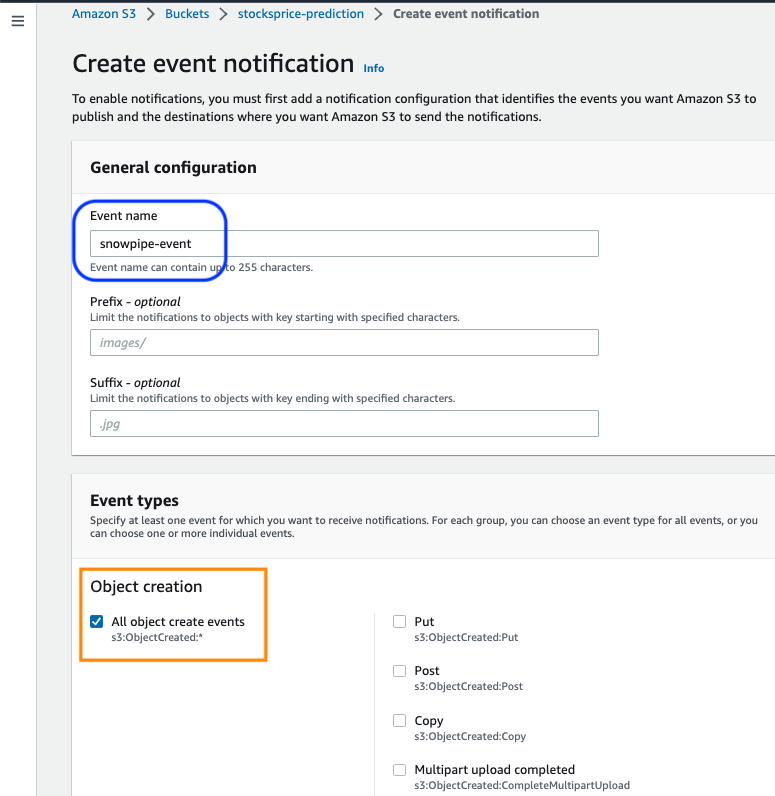

* Scroll down , in the **Destination** section select **SQS queue** & also select **Enter SQS queue ARN**.

* in the **SQS queue** text box paste **notification_channel** values copied earlier and click Save changes.

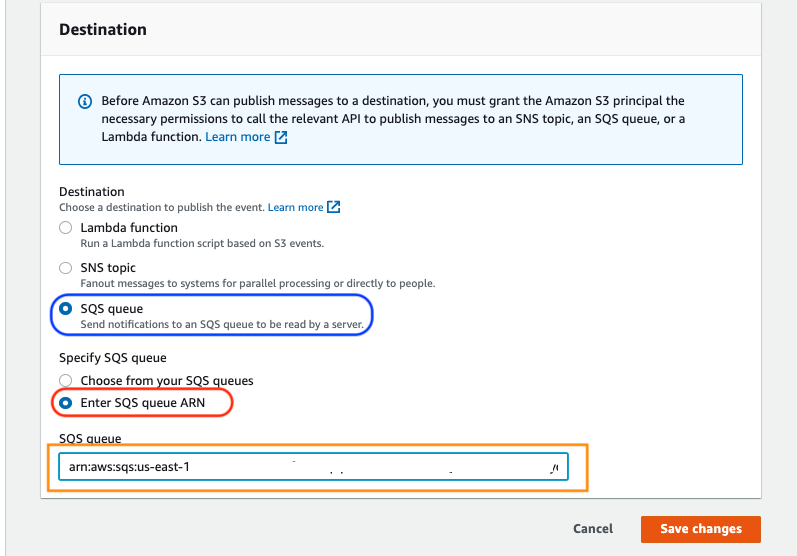



### Test & Monitor the Data Pipe Automation

All the required configurations are done, now its time to test data pile line & the automation.

#### Manually run the Lambda Function 

* Go to AWS console and open Lambda function **automate-web-scraping**
* Go to the Code Tab and then click he **Test** button.

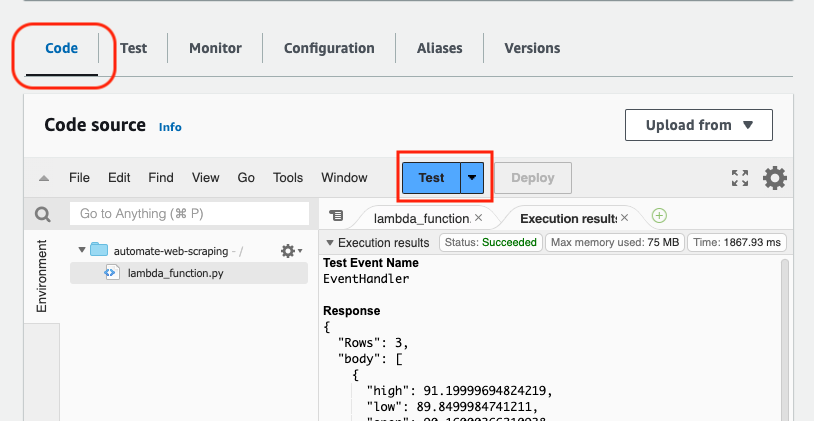

* Upon successful run, a new data file GOOG_YYYY-MM-DD_HHMM.csv should have created in the S3 Bucket.

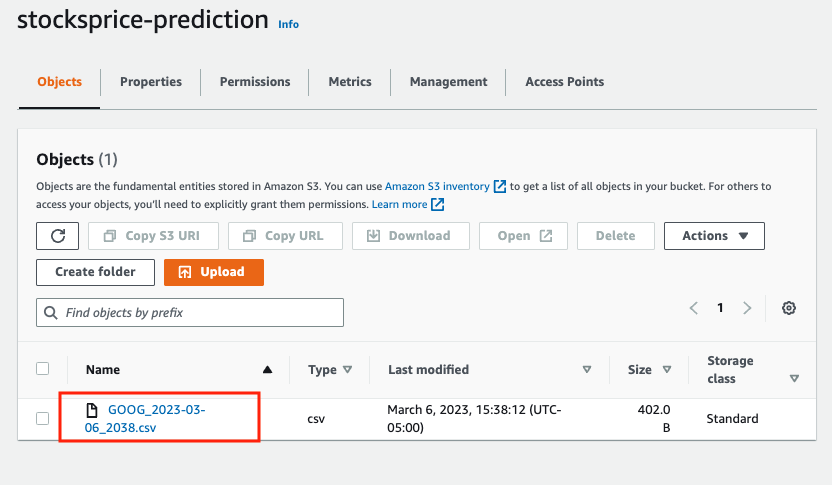

If everything went well, then the data present in the newly create file should automatically pump into the **historical_prices** table in snowflake. 

### Verify the data in the Snowflake 

#### Check the Data 
This the moment of truth, lets check the row count in historical_prices, it should be more than 4667 (since initial load GOOG.csv file contains 4667 rows)<br>

`select count(*) from historical_prices order by date desc;`<br>

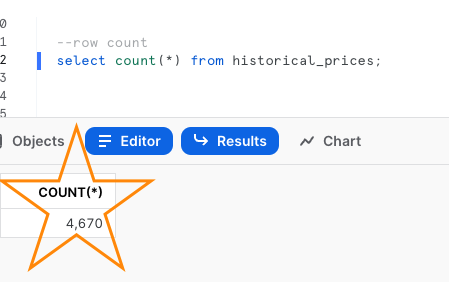<br>

Hurray! The data pipeline  automation has succeeded.<br>



#### Check the file copy history 

You can run the following query to check the file copy history on **historical_prices** table<br>

`select * from table(information_schema.copy_history(TABLE_NAME=>'historical_prices', START_TIME=> DATEADD(hours, -10000, CURRENT_TIMESTAMP())) ) order by 3 desc;`<br>


You should see the entry for the latest file that we generated via AWS Lambda function.<br>

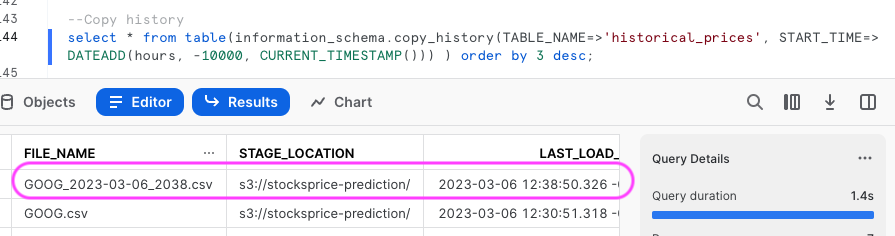<br>

#### Check the Snow pipe status 

Run following sql to check the current status of snowpipe, Status should be always RUNNING state to maintain the seamless integration.<br>

select SYSTEM$PIPE_STATUS( 'get_stocks_data_pipe');<br>

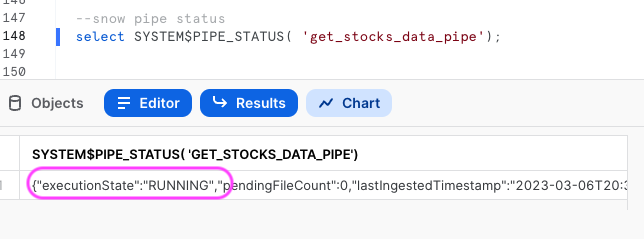<br>


StockPricePredictions Worksheet code is available [here](https://github.com/vinodvidhole/stockprice-predictions/blob/main/StockPricePredictions_WorkSheets.txt).<br>

AWS Lambda function will generate a daily price data file, which will be effortlessly loaded automatically.

Thanks to the exceptional capabilities of Snowflake and AWS, we constructed a data pipeline to ensure that the most up-to-date data is readily accessible on Snowflake tables for subsequent phases of Machine Learning.


## References
References to some useful links.
* https://blog.jovian.com/automate-web-scraping-using-python-aws-lambda-amazon-s3-amazon-eventbridge-cloudwatch-c4c982c35fa7
* https://github.com/vinodvidhole/stockprice-predictions/tree/main/AWS/AWSLambdaLayer/YF_39.zip
* https://github.com/vinodvidhole/stockprice-predictions/blob/main/AWS/lambda_function.py
* https://signup.snowflake.com/
* https://app.snowflake.com/
* https://github.com/vinodvidhole/stockprice-predictions/blob/main/AWS/GOOG.csv
* https://docs.snowflake.com/en/sql-reference/sql/copy-into-table
* https://github.com/vinodvidhole/stockprice-predictions/blob/main/StockPricePredictions_WorkSheets.txt
* https://github.com/vinodvidhole/stockprice-predictions
* https://medium.com/@vinodvidhole

## What’s Next

That’s all for the first article. I will see you in Part 2 where we will play with the data and build the Machine Learning models.

Here are the links to the whole guide:

Part 1: Data Collection And Data Storage (This article) TODO link

Part 2: Data Extraction, Preprocessing, EDA And Machine Learning Model development TODO link 

Part 3: Machine Learning Model deployment And Web App development TODO Link 


If you have any questions or any feedback feel free to post a comment or contact me on [LinkedIn](https://www.linkedin.com/in/vinodvidhole/). Thank you for reading and Until next time… Happy coding !!